<a href="https://www.kaggle.com/code/kennytanner/store-sales-forecasting-extensive-eda?scriptVersionId=120652030" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px

import datetime
from collections import defaultdict

import warnings
from IPython import get_ipython
get_ipython().config.InlineBackend.figure_format = 'retina'
warnings.simplefilter("ignore")

/kaggle/input/StoreSalesForecastingSub/submission.csv
/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Contents
## 1. Stores
## 2. Store Sales
#### 2.1. Data Quality and the Date Range
#### 2.2. Trends
#### 2.3. Seasonality
#### 2.4. Serial Dependence (Cycles)
## 3. Holidays
## 4. Transactions
## 5. Oil Prices

# 1. Stores

In [2]:
df_stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
df_stores = df_stores.set_index('store_nbr')
df_stores

city                           state type  cluster
store_nbr                                                             
1                  Quito                       Pichincha    D       13
2                  Quito                       Pichincha    D       13
3                  Quito                       Pichincha    D        8
4                  Quito                       Pichincha    D        9
5          Santo Domingo  Santo Domingo de los Tsachilas    D        4
6                  Quito                       Pichincha    D       13
7                  Quito                       Pichincha    D        8
8                  Quito                       Pichincha    D        8
9                  Quito                       Pichincha    B        6
10                 Quito                       Pichincha    C       15
11               Cayambe                       Pichincha    B        6
12             Latacunga                        Cotopaxi    C       15
13             Latacunga                        Cotopaxi    C       15
14              Riobamba                      Chimborazo    C        7
15                Ibarra                        Imbabura    C       15
16         Santo Domingo  Santo Domingo de los Tsachilas    C        3
17                 Quito                       Pichincha    C       12
18                 Quito                       Pichincha    B       16
19              Guaranda                         Bolivar    C       15
20                 Quito                       Pichincha    B        6
21         Santo Domingo  Santo Domingo de los Tsachilas    B        6
22                  Puyo                         Pastaza    C        7
23                Ambato                      Tungurahua    D        9
24             Guayaquil                          Guayas    D        1
25               Salinas                     Santa Elena    D        1
26             Guayaquil                          Guayas    D       10
27                 Daule                          Guayas    D        1
28             Guayaquil                          Guayas    E       10
29             Guayaquil                          Guayas    E       10
30             Guayaquil                          Guayas    C        3
31              Babahoyo                        Los Rios    B       10
32             Guayaquil                          Guayas    C        3
33               Quevedo                        Los Rios    C        3
34             Guayaquil                          Guayas    B        6
35                Playas                          Guayas    C        3
36              Libertad                          Guayas    E       10
37                Cuenca                           Azuay    D        2
38                  Loja                            Loja    D        4
39                Cuenca                           Azuay    B        6
40               Machala                          El Oro    C        3
41               Machala                          El Oro    D        4
42                Cuenca                           Azuay    D        2
43            Esmeraldas                      Esmeraldas    E       10
44                 Quito                       Pichincha    A        5
45                 Quito                       Pichincha    A       11
46                 Quito                       Pichincha    A       14
47                 Quito                       Pichincha    A       14
48                 Quito                       Pichincha    A       14
49                 Quito                       Pichincha    A       11
50                Ambato                      Tungurahua    A       14
51             Guayaquil                          Guayas    A       17
52                 Manta                          Manabi    A       11
53                 Manta                          Manabi    D       13
54             El Carmen                          Manabi    C        3

In [3]:
df_stores.groupby('city').city.count()

city
Ambato            2
Babahoyo          1
Cayambe           1
Cuenca            3
Daule             1
El Carmen         1
Esmeraldas        1
Guaranda          1
Guayaquil         8
Ibarra            1
Latacunga         2
Libertad          1
Loja              1
Machala           2
Manta             2
Playas            1
Puyo              1
Quevedo           1
Quito            18
Riobamba          1
Salinas           1
Santo Domingo     3
Name: city, dtype: int64

The store types can be found: (https://www.corporacionfavorita.com/en/brands/commercial-area/)

And I believe that the clusters are simply a measure of the number of similar stores around.

# 2. Store Sales
The number of items sold, not total sales value.
## 2.1. Data Quality and the Date Range
Losing data sucks. But with bad and/or patchy data, better results can be achieved only training on the best.

In [4]:
df_sales = pd.read_csv(
    "/kaggle/input/store-sales-time-series-forecasting/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'int8',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,)

In [5]:
df_sales

date  store_nbr                      family        sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000000   
1       2013-01-01          1                   BABY CARE     0.000000   
2       2013-01-01          1                      BEAUTY     0.000000   
3       2013-01-01          1                   BEVERAGES     0.000000   
4       2013-01-01          1                       BOOKS     0.000000   
...            ...        ...                         ...          ...   
3000883 2017-08-15          9                     POULTRY   438.132996   
3000884 2017-08-15          9              PREPARED FOODS   154.552994   
3000885 2017-08-15          9                     PRODUCE  2419.729004   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000000   
3000887 2017-08-15          9                     SEAFOOD    16.000000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 5 columns]

In [6]:
df_sales[df_sales.isna().any(axis=1)].count()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
Missing_dates = pd.date_range(start="2013-01-01", end="2017-08-15").difference(df_sales.date)
Missing_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

The Christmas days are all missing!

But this is without looking at each individual store and family of items. So there may be many more hidden...

In [8]:
len(df_sales.store_nbr.unique())

54

In [9]:
departments = list(df_sales.family.unique())
departments

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

In [10]:
Missing_dates = set(Missing_dates)

for store_nbr in range(1,55):
    for family in departments:
        for date in list(pd.date_range(start="2013-01-01", end="2017-08-15").difference(df_sales.date[(df_sales.store_nbr== store_nbr) & (df_sales.family == family)])):
             Missing_dates.add(date)
                
Missing_dates

{Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')}

So it looks like it's only those Christmas days.

In [11]:
df_sales['date'] = df_sales.date.dt.to_period('D')
df_sales = df_sales.set_index(['store_nbr', 'family', 'date']).sort_index() # lets get those store numbers sorted right

# and to sort by date
df_sales = df_sales.unstack(['store_nbr', 'family'])
df_sales = df_sales.stack(['store_nbr', 'family'])
df_sales = df_sales[['sales','onpromotion']] # with sales before promotion
df_sales

sales  onpromotion
date       store_nbr family                                             
2013-01-01 1         AUTOMOTIVE                    0.000000            0
                     BABY CARE                     0.000000            0
                     BEAUTY                        0.000000            0
                     BEVERAGES                     0.000000            0
                     BOOKS                         0.000000            0
...                                                     ...          ...
2017-08-15 54        POULTRY                      59.618999            0
                     PREPARED FOODS               94.000000            0
                     PRODUCE                     915.370972           76
                     SCHOOL AND OFFICE SUPPLIES    0.000000            0
                     SEAFOOD                       3.000000            0

[3000888 rows x 2 columns]

In [12]:
def sales_by_family_by_store(df=df_sales, NUM_FAMILIES=33, NUM_STORES=54):
    """Default will show each family of goods at each store. But you may limit these.
    Insert the number of families and/or the number of stores that you wish to inspect.
    There are a total of 33 families of goods and 54 stores."""
    if (NUM_FAMILIES >33) or (NUM_STORES >54):
        return "max number of famlies=33 , max number of stores=54"
    else:
        for STORE_NBR in range(1, NUM_STORES+1):
            plt.clf()
            y_for_one_store = df.loc[:, STORE_NBR, :].sales.unstack(['family'])
            families = y_for_one_store.columns[0:NUM_FAMILIES]

            axs = y_for_one_store.loc(axis=1)[families].plot(
                subplots=True, sharex=True, figsize=(16, 3*NUM_FAMILIES), alpha=0.6
            )

            for ax, family in zip(axs, families):
                ax.legend([])
                ax.set_ylabel(f'Store {STORE_NBR} Sales')
                ax.set_title(family.title())
                ax.tick_params(labelbottom=True)
            plt.tight_layout()
            plt.show()

<Figure size 640x480 with 0 Axes>

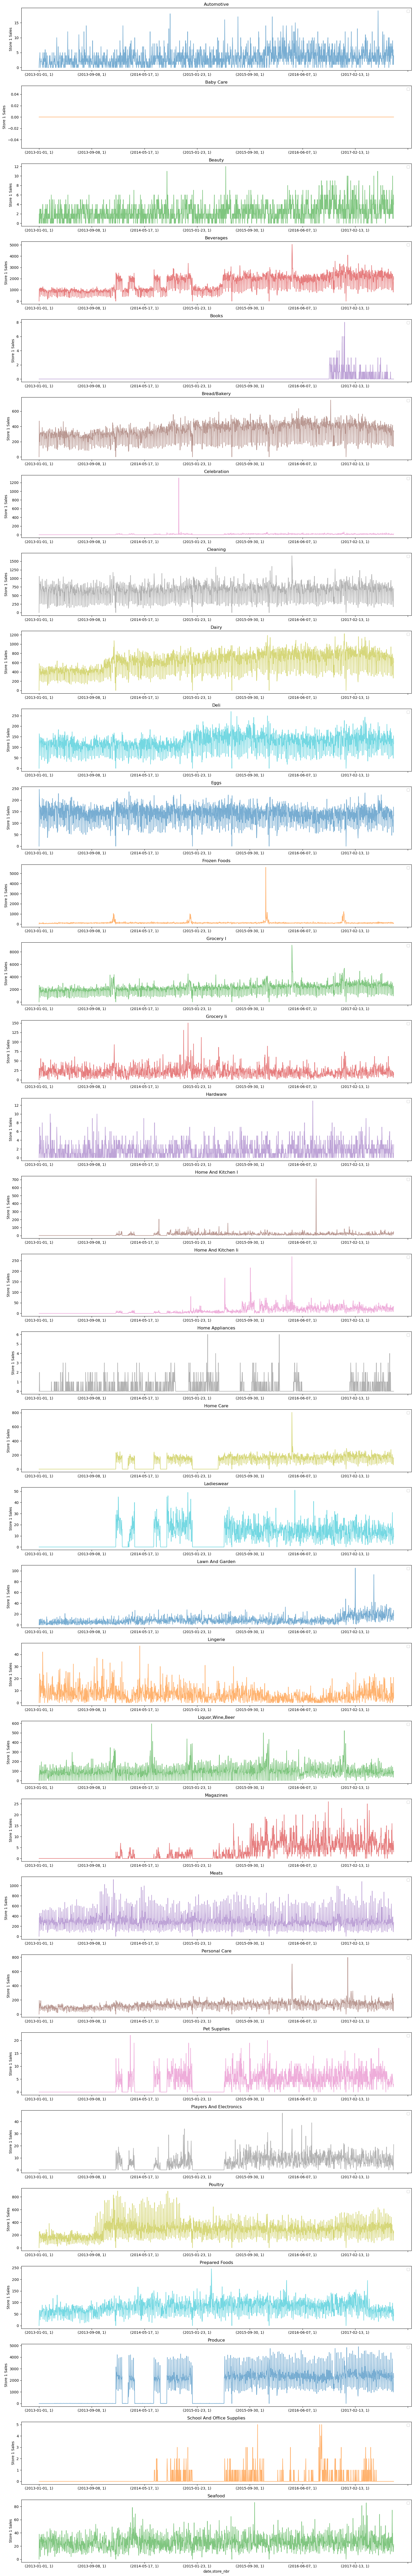

In [13]:
sales_by_family_by_store(df_sales, 33, 1)

- For many families of items, in many of the stores, there are significant periods with no sales.
- This is not great for training.
- Please take a look for yourself as this notebook would get very long if I did not reduce the number of plots.
- This is particulary true the futher back in the data you go.
- Perhaps these goods were sold for trial periods, data collection was poor or maybe even the volcanic erruption or other external factors interfered. Either way, improvements have been made and it may well be better to exclude this earlier data from the training set.

In [14]:
def sales_of(df=df_sales, family='AUTOMOTIVE', STORE_NBR=1):
    """Default will show each family of goods at each store. But you may limit these.
    Insert the number of families and/or the number of stores that you wish to inspect.
    There are a total of 33 families of goods and 54 stores."""
    if (family not in departments) or (STORE_NBR >54):
        print(f"max number of stores=54 , & departments (families) available as {departments}")
    else:
            df_sales.sales.loc[:, STORE_NBR, family].plot(figsize=(16, 3), alpha=0.6)
            plt.title(f"Store {STORE_NBR} {family.title()} Sales")

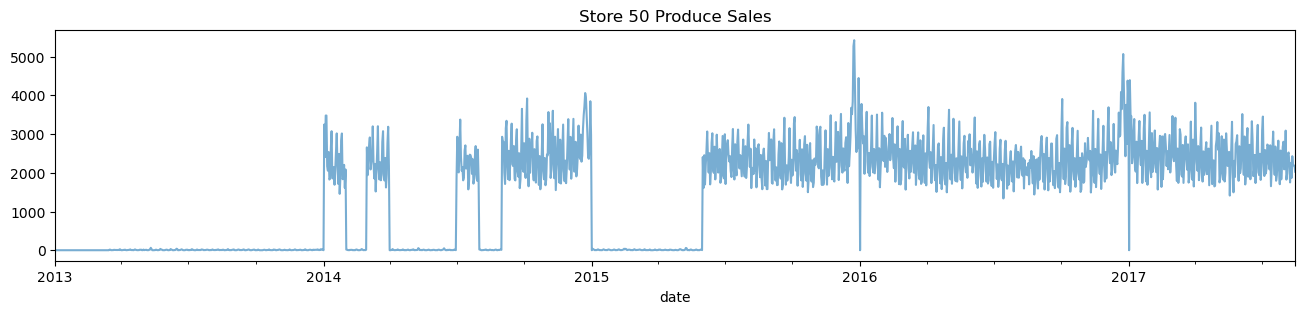

In [15]:
sales_of(family='PRODUCE', STORE_NBR=50)

## 2.2. Trends

The overall average shows a general increase in sales over time.

In [16]:
total_sales = df_sales.groupby('date').sales.sum().squeeze().reset_index()
total_sales = total_sales.set_index('date')

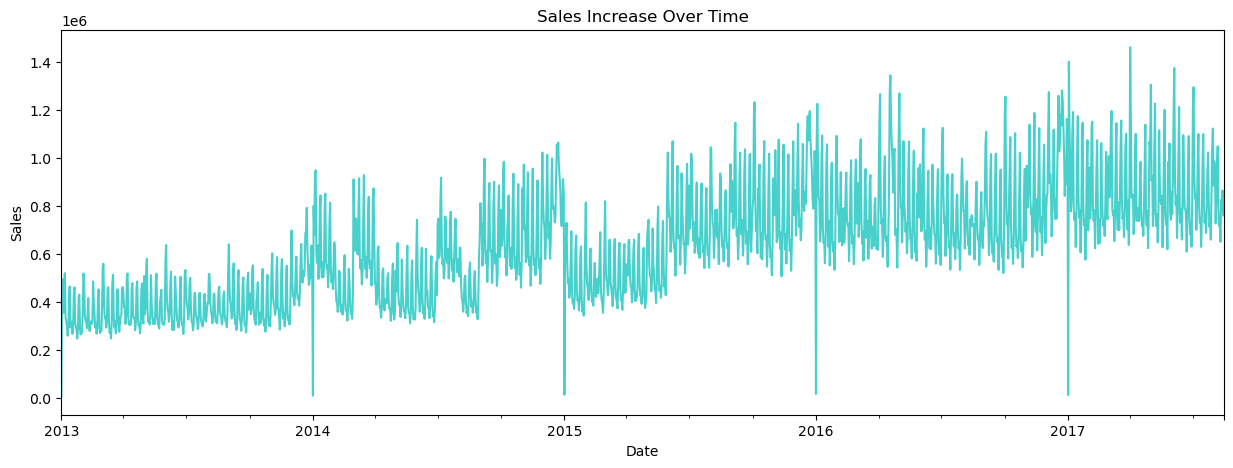

In [17]:
total_sales.plot(legend=False, color='mediumturquoise', figsize=(15, 5))
plt.title('Sales Increase Over Time')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()

But we can take a deeper delve into each individual store and family of items.

- These functions allow you to take a look by family across the stores
- Or by store, across the item sold in that store

In [18]:
def trends(df=df_sales, NUM_FAMILIES=33, NUM_STORES=54, by_family=False):
    """Default will show each family of goods at each store. But you may limit these.
    Insert the number of families and/or the number of stores that you wish to inspect.
    There are a total of 33 families of goods and 54 stores.
       by_family=True 
                       will collect the same family togther across multiple stores."""
    if (NUM_FAMILIES >33) or (NUM_STORES >54):
        return "max number of famlies=33 , max number of stores=54"
    else:
        if by_family:
            families = df_sales.loc[:, 1, :].sales.unstack(['family']).columns[0:NUM_FAMILIES]
            for family in families:
                df_store = df_sales.sales.loc[:,:, family].unstack(['store_nbr']).copy()
                df_store['Time'] = pd.to_numeric(df_store.index)
                plt.clf()
                fig, ax = plt.subplots(NUM_STORES, 1, figsize=(16, 3*NUM_STORES))
                for STORE_NBR in range(1, NUM_STORES+1):
                    plt.subplot(NUM_STORES, 1, STORE_NBR)
                    plt.plot(df_store['Time'], df_store[STORE_NBR], color='0.75')
                    sns.regplot(x='Time', y=df_store[STORE_NBR], data=df_store, color='yellow', ci=None, scatter_kws=dict(color='0.25'))
                    plt.xticks([])
                    plt.ylabel('Sales')
                    plt.title(f'Store Number {STORE_NBR}')

                fig.suptitle(family.title(), fontsize= 15, y=1)
                fig.tight_layout()
                plt.show()
        else:    
            for STORE_NBR in range(1, NUM_STORES+1):
                df_store = df_sales.loc[:, STORE_NBR, :].sales.unstack(['family']).copy()
                families = df_store.columns[0:NUM_FAMILIES]
                df_store['Time'] = pd.to_numeric(df_store.index)
                plt.clf()
                fig, ax = plt.subplots(NUM_FAMILIES, 1, figsize=(16, 3*NUM_FAMILIES))
                for i, family in enumerate(families):
                    plt.subplot(NUM_FAMILIES, 1, i+1)
                    plt.plot('Time', family, data=df_store, color='0.75')
                    sns.regplot(x='Time', y=family, data=df_store, color='yellow', ci=None, scatter_kws=dict(color='0.25'))
                    plt.xticks([])
                    plt.ylabel('Sales')
                    plt.title(family.title())


                fig.suptitle('Store Number {}'.format(STORE_NBR), fontsize= 15, y=1)
                fig.tight_layout()
                plt.show()

<Figure size 640x480 with 0 Axes>

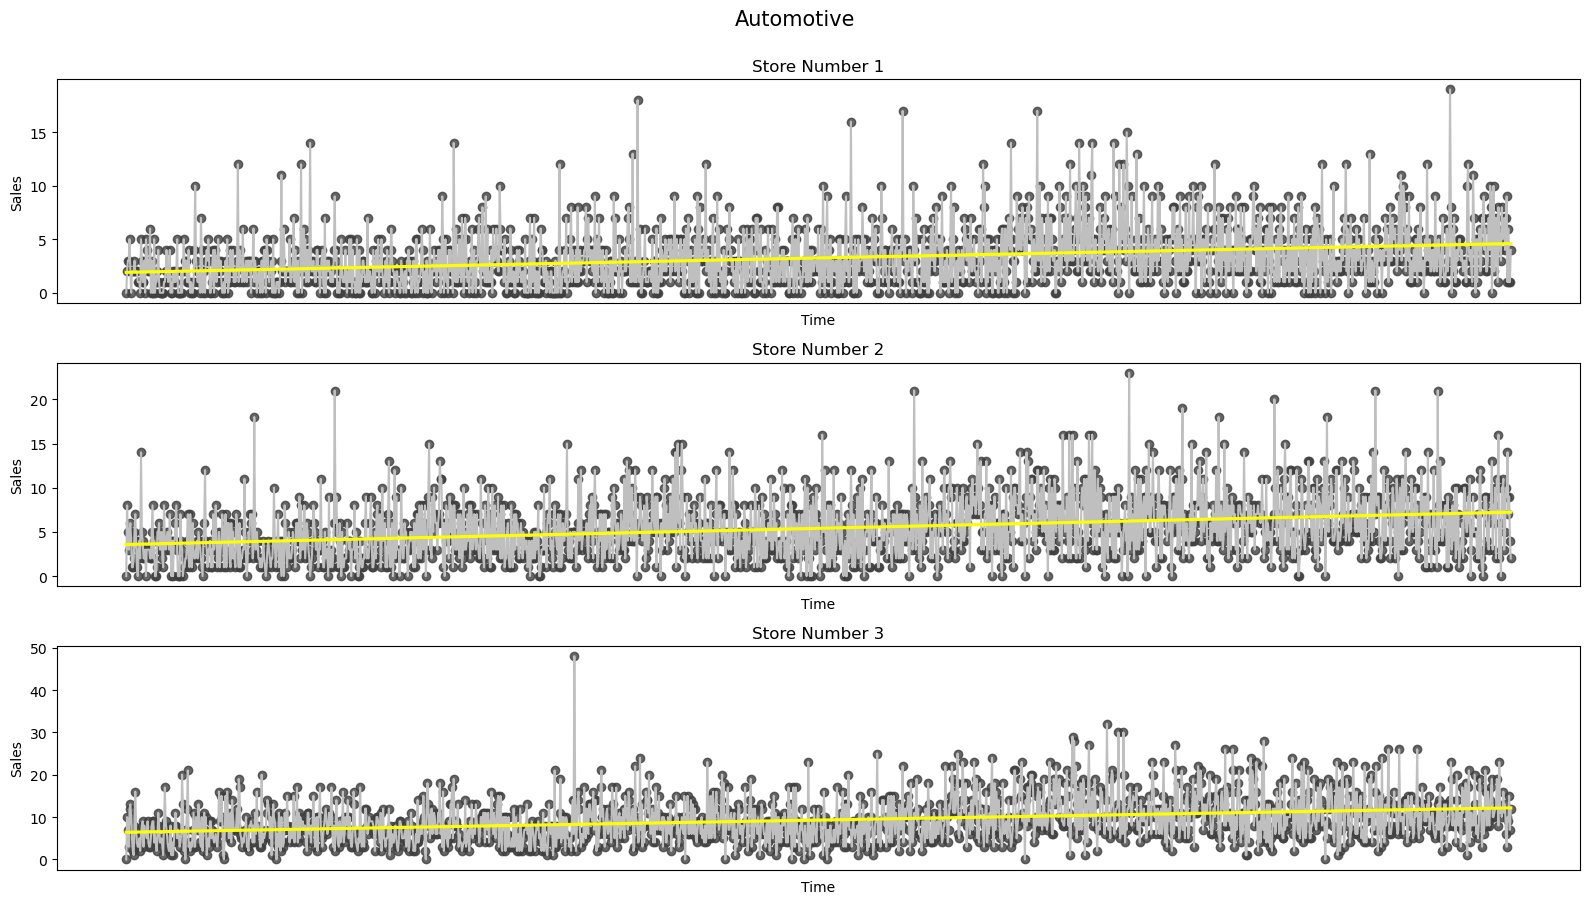

In [19]:
trends(df=df_sales, NUM_FAMILIES=1, NUM_STORES=3, by_family=True)

- But this function I created to look at individual cases

In [20]:
def trend_in(df=df_sales, family='BEVERAGES', STORE_NBR=50):
    if (family not in departments) or (STORE_NBR >54):
        print(f"max number of stores=54 , & departments (families) available as {departments}")
    else:
            df_store = df_sales.loc[:, STORE_NBR, family].copy()
            df_store.index = df_store.index.get_level_values('date')
            df_store['Time'] = pd.to_numeric(df_store.index)
            plt.figure(figsize=(15,5))
            plt.plot(df_store.Time, df_store.sales, color='0.75')
            sns.regplot(x='Time', y='sales', data=df_store, color='yellow', ci=None, scatter_kws=dict(color='0.25'))
            plt.xticks([])
            plt.ylabel('Sales')
            
            plt.title(f'Store Number {STORE_NBR} {family.title()} Sales')

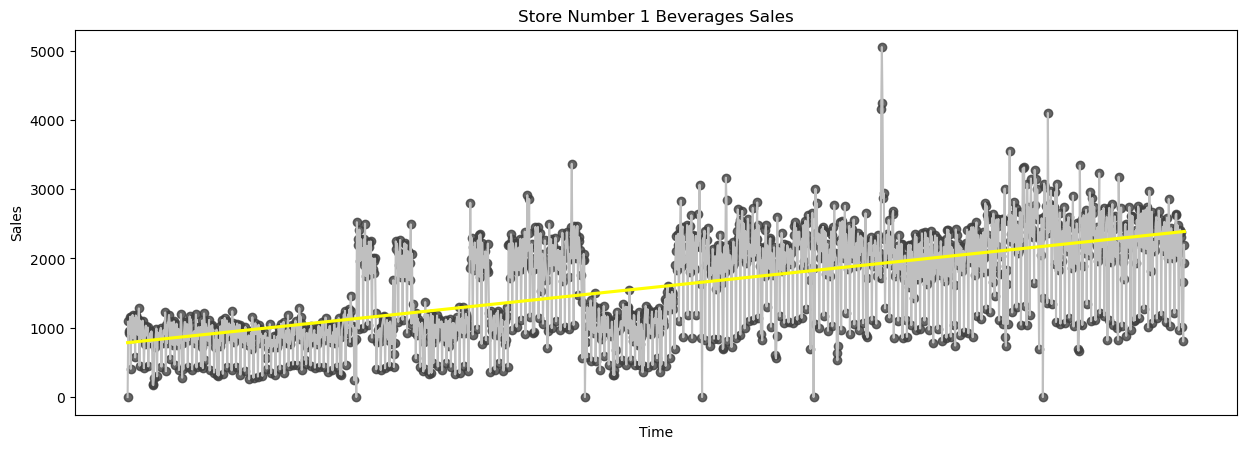

In [21]:
trend_in(STORE_NBR=1)

Most of families of goods in these stores end up showing some pretty similar trends. And the same is true across the stores too. Linear regression models should do well to capture these, but there is also a lot of variance! And at a glance it does look like some seasonality can be seen. So let's take a better look and see if we can shine a light on some

## 2.3. Seasonality

In [22]:
df_sales['date']=df_sales.index.get_level_values('date')
df_sales['day_of_week'] = df_sales.date.dt.dayofweek
df_sales['day_of_month'] = df_sales.date.dt.day
df_sales['day_of_year'] = df_sales.date.dt.dayofyear
df_sales['month'] = df_sales.date.dt.month
df_sales['year'] = df_sales.date.dt.year
df_sales.drop(['date'], axis=1, inplace=True)

In [23]:
def seasonality_sum_plot(df = df_sales, season = 'week', families = departments):
    """ Potential Seasons to explore can be selected using the season parameter
    seasons available are: 'week' 'month' year' 'year by month' """
    if season == 'week':
        df1 = df.groupby(['family','day_of_week']).sales.sum().reset_index()
        for family in families:
            x = df1[df1['family']== family].day_of_week.values.tolist()
            y = df1[df1['family']== family].sales.values.tolist() 
            plt.plot(x, y, label=family)

        plt.xlabel('Day of the Week')
        plt.ylabel('Sales')
        plt.legend(bbox_to_anchor =(1, 1))
        plt.title('Total Sales on Each Weekday')
        plt.show()
    elif season == 'month':
        df1 = df.groupby(['family','day_of_month']).sales.sum().reset_index()
        for family in families:
            x = df1[df1['family']== family].day_of_month.values.tolist()
            y = df1[df1['family']== family].sales.values.tolist() 
            plt.plot(x, y, label=family)

        plt.xlabel('Day of the Month')
        plt.ylabel('Sales')
        plt.legend(bbox_to_anchor =(1, 1))
        plt.title('Total Sales on Each Day of the Month')
        plt.show()
    elif season == 'year':
        df1 = df.groupby(['family','day_of_year']).sales.sum().reset_index()
        for family in families:
            x = df1[df1['family']== family].day_of_year.values.tolist()
            y = df1[df1['family']== family].sales.values.tolist() 
            plt.plot(x, y, label=family)

        plt.xlabel('Day of the Year')
        plt.ylabel('Sales')
        plt.legend(bbox_to_anchor =(1, 1))
        plt.title('Total Sales Each Day Throughout the Year')
        plt.show()
    elif season == 'year by month':
        df1 = df.groupby(['family','month']).sales.sum().reset_index()
        for family in families:
            x = df1[df1['family']== family].month.values.tolist()
            y = df1[df1['family']== family].sales.values.tolist() 
            plt.plot(x, y, label=family)

        plt.xlabel('Month')
        plt.ylabel('Sales')
        plt.legend(bbox_to_anchor =(1, 1))
        plt.title('Total Sales Each Month Over Data')
        plt.show()
    else:
        print(""" Unavailable season...
        Potential Seasons to explore can be selected using the season parameter 
        seasons available are: 'week' 'month' year' """)

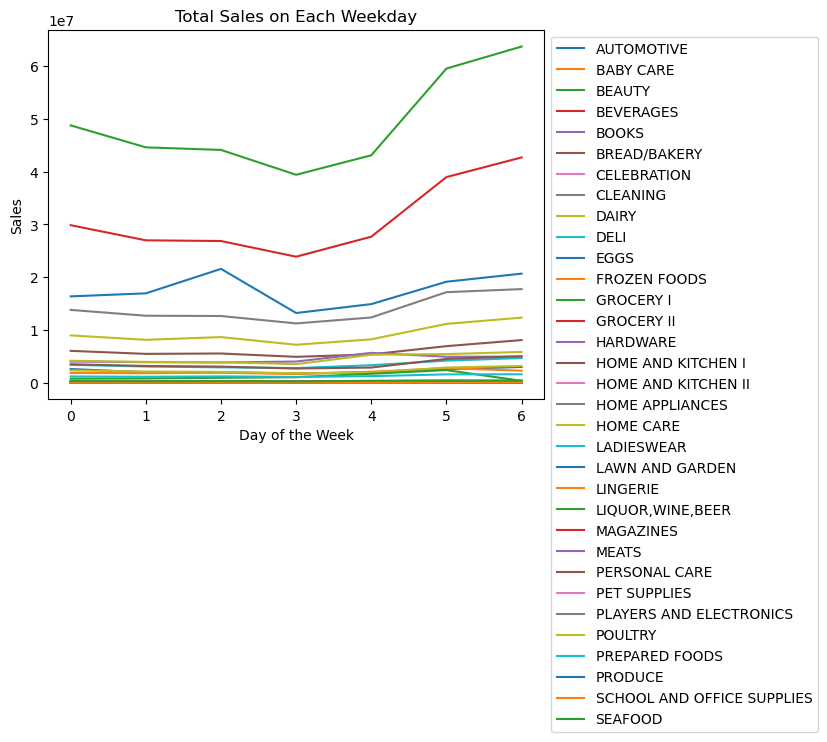

In [24]:
seasonality_sum_plot(season='week')

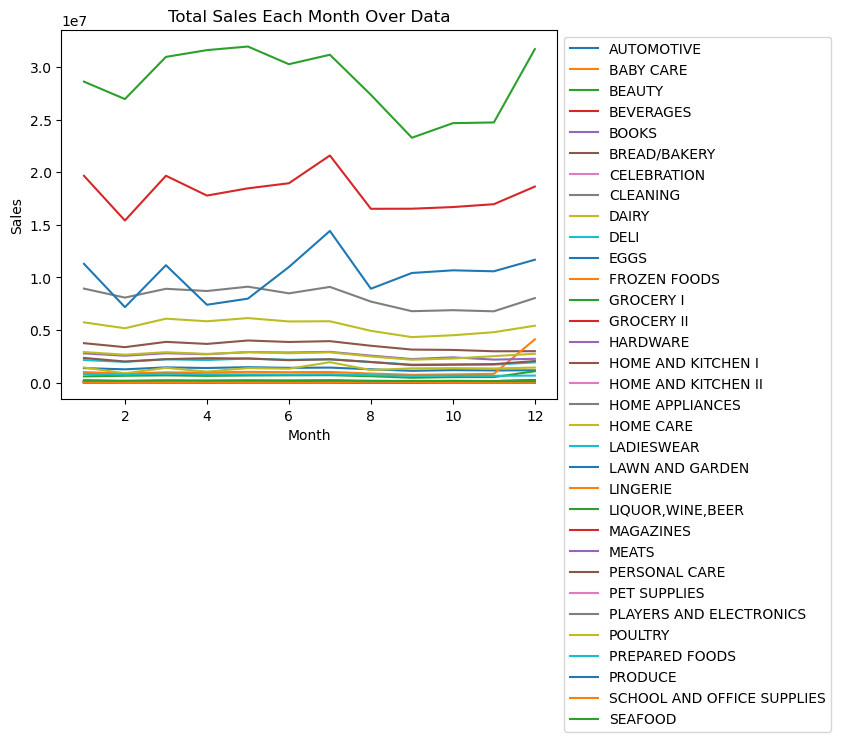

In [25]:
seasonality_sum_plot(season='year by month')

Makes sense. Higher sales on the weekends and around the holiday season.

Let's take a look at the averages too. The opening of new stores is effecting this last sum plot and using the mean is an easy way around that.

In [26]:
def seasonality_mean_plot(df = df_sales, season = 'week', families = departments):
    """ Potential Seasons to explore can be selected using the season parameter
    seasons available are: 'week' 'month' year' 'year by month' """
    if season == 'week':
        df1 = df.groupby(['family','day_of_week']).sales.mean().reset_index()
        for family in families:
            x = df1[df1['family']== family].day_of_week.values.tolist()
            y = df1[df1['family']== family].sales.values.tolist() 
            plt.plot(x, y, label=family)

        plt.xlabel('Day of the Week')
        plt.ylabel('Sales')
        plt.legend(bbox_to_anchor =(1, 1))
        plt.title('Mean Sales on Each Weekday')
        plt.show()
    elif season == 'month':
        df1 = df.groupby(['family','day_of_month']).sales.mean().reset_index()
        for family in families:
            x = df1[df1['family']== family].day_of_month.values.tolist()
            y = df1[df1['family']== family].sales.values.tolist() 
            plt.plot(x, y, label=family)

        plt.xlabel('Day of the Month')
        plt.ylabel('Sales')
        plt.legend(bbox_to_anchor =(1, 1))
        plt.title('Mean Sales on Each Day of the Month')
        plt.show()
    elif season == 'year':
        df1 = df.groupby(['family','day_of_year']).sales.mean().reset_index()
        for family in families:
            x = df1[df1['family']== family].day_of_year.values.tolist()
            y = df1[df1['family']== family].sales.values.tolist() 
            plt.plot(x, y, label=family)

        plt.xlabel('Day of the Year')
        plt.ylabel('Sales')
        plt.legend(bbox_to_anchor =(1, 1))
        plt.title('Mean Sales Each Day Throughout the Year')
        plt.show()
    elif season == 'year by month':
        df1 = df.groupby(['family','month']).sales.mean().reset_index()
        for family in families:
            x = df1[df1['family']== family].month.values.tolist()
            y = df1[df1['family']== family].sales.values.tolist() 
            plt.plot(x, y, label=family)

        plt.xlabel('Month')
        plt.ylabel('Sales')
        plt.legend(bbox_to_anchor =(1, 1))
        plt.title('Mean Sales Each Month')
        plt.show()
    else:
        print(""" Unavailable season...
        Potential Seasons to explore can be selected using the season parameter 
        seasons available are: 'week' 'month' year' """)

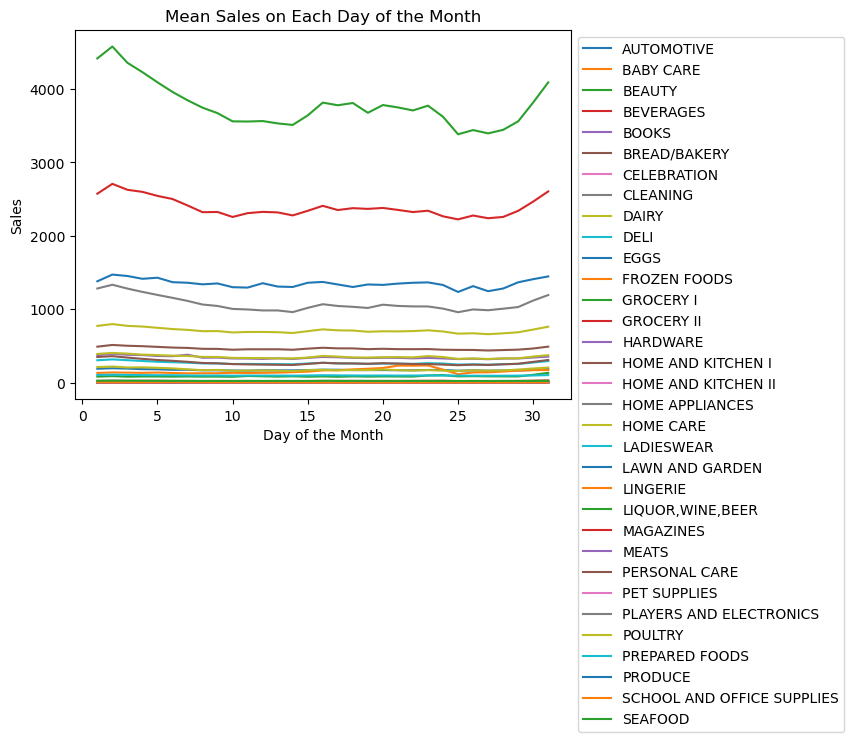

In [27]:
seasonality_mean_plot(season='month')

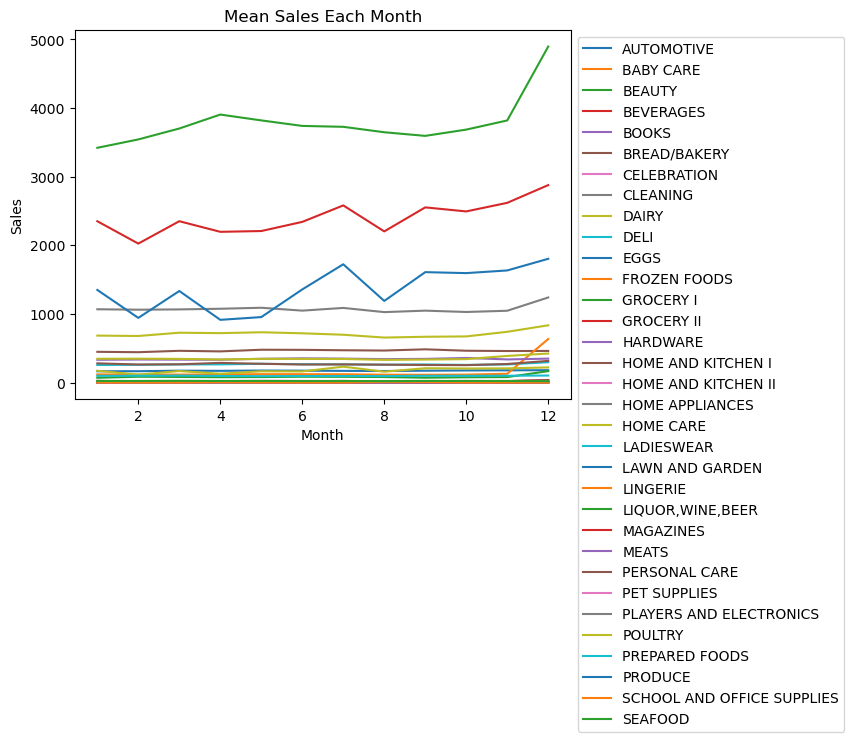

In [28]:
seasonality_mean_plot(season='year by month')

So it looks like a good plan include some seasonal features!

I can also see an uptick on, and after, the 15th of the month. This corresponds to one of the pulic sector wage days in Ecuador. And then the much larger increase along with the one at the end of the month, when I expect many of the private sector workers also get paid.

A feature identifying these days and perhaps some after as well looks appropriate too.

## 2.4. Serial Dependence (Cycles)
Movements of the target variable may have an affect of its own. While unlikely to be as volatile stock market, supermarkets are expected to experiance these affects as well. It could be everyone rushing to buy the last roll of toilet paper before the limited stocks sell out, or it could be far more everyday. Say a type of food gets popular and everyone wants to try it. Or an especially cool beauty product hits the market. The more folks the go out to buy it, the more people see it around town, and/or hear how great it is, and feel the urge to run down to the shop and try it out for themselves.

In [29]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='orchid' )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, color= 'gold', **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def look_for_serial_dependency(df=df_sales, NUM_STORES=54, families=departments):
    for STORE_NBR in range(1, NUM_STORES+1):
        for family in families:
            df1=df[(df.index.get_level_values('store_nbr')==STORE_NBR) & (df.index.get_level_values('family')==family)]
            display(df1)
            if df1[df1.sales > 0].empty :
                print("Store #{} made no sales in {} department".format(STORE_NBR, family))
                continue
            plt.clf()
            fig, ax = plt.subplots(figsize=(20, 8))
            _ = plot_pacf(df1.sales, lags=12, method='ywm', ax=ax)
            _ = plot_lags(df1.sales, lags=12, nrows=2)
            fig.suptitle("Store #{} {}".format(STORE_NBR, family.title()), fontsize=15)
            plt.show()

sales  onpromotion  day_of_week  day_of_month  \
date       store_nbr family                                                  
2013-01-01 1         BEAUTY    0.0            0            1             1   
2013-01-02 1         BEAUTY    2.0            0            2             2   
2013-01-03 1         BEAUTY    0.0            0            3             3   
2013-01-04 1         BEAUTY    3.0            0            4             4   
2013-01-05 1         BEAUTY    3.0            0            5             5   
...                            ...          ...          ...           ...   
2017-08-11 1         BEAUTY    1.0            1            4            11   
2017-08-12 1         BEAUTY    3.0            1            5            12   
2017-08-13 1         BEAUTY    1.0            0            6            13   
2017-08-14 1         BEAUTY    6.0            1            0            14   
2017-08-15 1         BEAUTY    4.0            1            1            15   

                             day_of_year  month  year  
date       store_nbr family                            
2013-01-01 1         BEAUTY            1      1  2013  
2013-01-02 1         BEAUTY            2      1  2013  
2013-01-03 1         BEAUTY            3      1  2013  
2013-01-04 1         BEAUTY            4      1  2013  
2013-01-05 1         BEAUTY            5      1  2013  
...                                  ...    ...   ...  
2017-08-11 1         BEAUTY          223      8  2017  
2017-08-12 1         BEAUTY          224      8  2017  
2017-08-13 1         BEAUTY          225      8  2017  
2017-08-14 1         BEAUTY          226      8  2017  
2017-08-15 1         BEAUTY          227      8  2017  

[1684 rows x 7 columns]

<Figure size 640x480 with 0 Axes>

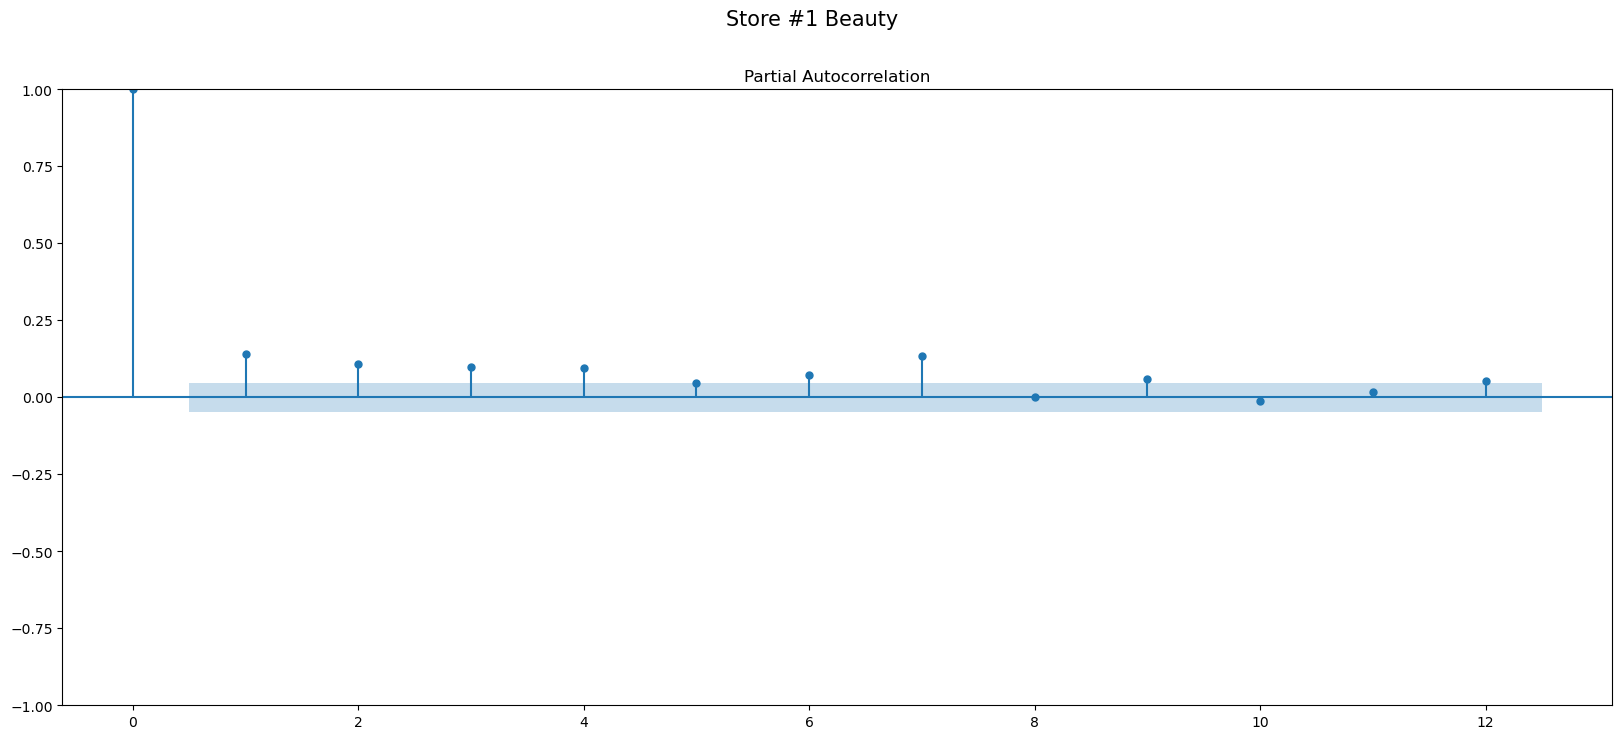

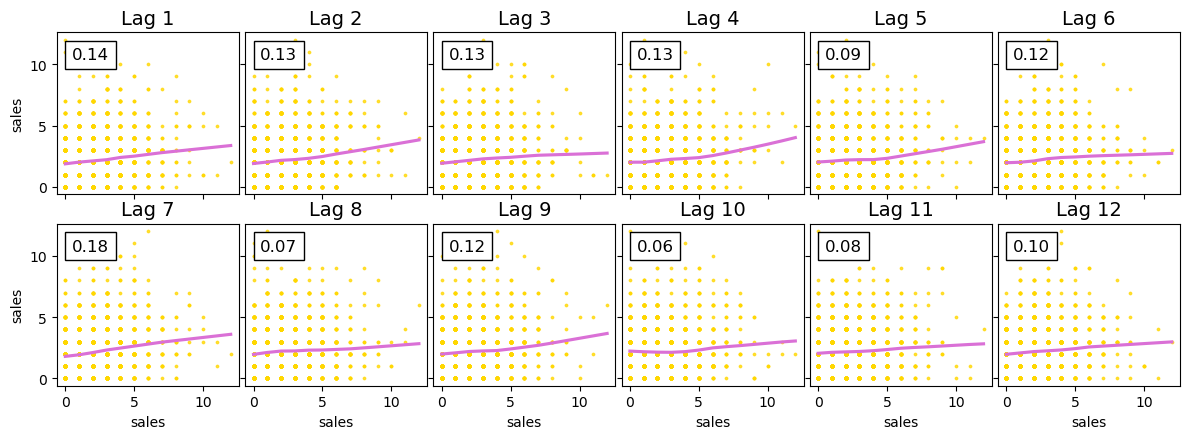

In [30]:
look_for_serial_dependency(df_sales, 1, ['BEAUTY'])

Quite mild, but still some, linear dependence. And positive partial autocorrelation for pretty much the whole week.

# 3. Holidays

In [31]:
df_holidays = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
df_holidays

date        type    locale locale_name  \
0    2012-03-02     Holiday     Local       Manta   
1    2012-04-01     Holiday  Regional    Cotopaxi   
2    2012-04-12     Holiday     Local      Cuenca   
3    2012-04-14     Holiday     Local    Libertad   
4    2012-04-21     Holiday     Local    Riobamba   
..          ...         ...       ...         ...   
345  2017-12-22  Additional  National     Ecuador   
346  2017-12-23  Additional  National     Ecuador   
347  2017-12-24  Additional  National     Ecuador   
348  2017-12-25     Holiday  National     Ecuador   
349  2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

In [32]:
Number_of_City_Holidays = defaultdict(int)
Number_of_State_Holidays = defaultdict(int)
Number_of_National_Holidays = defaultdict(int)

for holiday_locale_name in df_holidays.locale_name:
    if holiday_locale_name in df_stores.city.unique():
        Number_of_City_Holidays[holiday_locale_name] +=1
        
    elif holiday_locale_name in df_stores.state.unique():
        Number_of_State_Holidays[holiday_locale_name] +=1
        
    elif holiday_locale_name == 'Ecuador':
        Number_of_National_Holidays[holiday_locale_name] +=1
        
    else:
        print(f"!!!! A {holiday} is neither city, state or national !!!!")
        
City_Holidays_df = pd.DataFrame([Number_of_City_Holidays], index=['Count'])
City_Holidays_df["Total"] = City_Holidays_df.sum(axis=1)
City_Holidays_df = City_Holidays_df.T
City_Holidays_df["Percentage"] = City_Holidays_df.apply(lambda x: 100*x/City_Holidays_df.Count.iloc[-1]).astype('int')
City_Holidays_df

Count  Percentage
Manta              6           3
Cuenca             7           4
Libertad           6           3
Riobamba          12           7
Puyo               6           3
Guaranda          12           7
Latacunga         12           7
Machala            6           3
Santo Domingo      6           3
El Carmen          6           3
Cayambe            6           3
Esmeraldas         6           3
Ambato            12           7
Ibarra             7           4
Quevedo            6           3
Quito             13           8
Loja               6           3
Salinas            6           3
Guayaquil         11           7
Total            152         100

In [33]:
State_Holidays_df = pd.DataFrame([Number_of_State_Holidays], index=['Count'])
State_Holidays_df["Total"] = State_Holidays_df.sum(axis=1)
State_Holidays_df = State_Holidays_df.T
State_Holidays_df["Percentage"] = State_Holidays_df.apply(lambda x: 100*x/State_Holidays_df.Count.iloc[-1]).astype('int')
State_Holidays_df

Count  Percentage
Cotopaxi                            6          25
Imbabura                            6          25
Santo Domingo de los Tsachilas      6          25
Santa Elena                         6          25
Total                              24         100

In [34]:
Holiday_Totals_df = pd.DataFrame([Number_of_National_Holidays], index=['Count'])
Holiday_Totals_df["State"] = State_Holidays_df.Count.loc["Total"]
Holiday_Totals_df["City"] = City_Holidays_df.Count.loc["Total"]
Holiday_Totals_df = Holiday_Totals_df.rename(columns={'Ecuador':"National"})
Holiday_Totals_df["Total"] = Holiday_Totals_df.sum(axis=1)
Holiday_Totals_df = Holiday_Totals_df.T
Holiday_Totals_df["Percentage"] = Holiday_Totals_df.apply(lambda x: 100*x/Holiday_Totals_df.Count.iloc[-1]).astype('int')
Holiday_Totals_df

Count  Percentage
National    174          49
State        24           6
City        152          43
Total       350         100

In [35]:
City_Holidays_df.index.values

array(['Manta', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo', 'Guaranda',
       'Latacunga', 'Machala', 'Santo Domingo', 'El Carmen', 'Cayambe',
       'Esmeraldas', 'Ambato', 'Ibarra', 'Quevedo', 'Quito', 'Loja',
       'Salinas', 'Guayaquil', 'Total'], dtype=object)

In [36]:
df_stores['City_Hols'] = df_stores.city.apply(lambda x: City_Holidays_df.loc[x].Count if x in City_Holidays_df.index.values else 0)
df_stores['State_Hols'] = df_stores.state.apply(lambda x: State_Holidays_df.loc[x].Count if x in State_Holidays_df.index.values else 0)
df_stores['National_Hols'] = Holiday_Totals_df.loc['National'].Count
df_stores["Percentage_Regional_Holidays"] = (100*(df_stores.City_Hols + df_stores.State_Hols)/(df_stores.City_Hols + df_stores.State_Hols + df_stores.National_Hols)).astype('int')
display(df_stores.sort_values(by="Percentage_Regional_Holidays", ascending=False).head(3))
display(df_stores.sort_values(by="Percentage_Regional_Holidays", ascending=False).tail(3))

city      state type  cluster  City_Hols  State_Hols  \
store_nbr                                                              
12         Latacunga   Cotopaxi    C       15         12           6   
13         Latacunga   Cotopaxi    C       15         12           6   
1              Quito  Pichincha    D       13         13           0   

           National_Hols  Percentage_Regional_Holidays  
store_nbr                                               
12                   174                             9  
13                   174                             9  
1                    174                             6

city     state type  cluster  City_Hols  State_Hols  \
store_nbr                                                            
27            Daule    Guayas    D        1          0           0   
35           Playas    Guayas    C        3          0           0   
31         Babahoyo  Los Rios    B       10          0           0   

           National_Hols  Percentage_Regional_Holidays  
store_nbr                                               
27                   174                             0  
35                   174                             0  
31                   174                             0

So the regional holidays are only a small portion of the holidays for the majority of the stores.

# 4. Transactions

In [37]:
df_transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv", parse_dates=['date'])
df_transactions['date'] = df_transactions.date.dt.to_period('D')
df_transactions=df_transactions.set_index('date')

In [38]:
def transactions_over_time(NUM_STORES=54, store=None, only_all=False):
    """ Can select an individual store with store parameter
           Default shows all stores
           only_all=True will only show all stores, without plotting each store separately"""    
    if store:
        print('Since store entered only store shown.')
        df_transactions.transactions[df_transactions.store_nbr==store].plot(color='mediumturquoise', figsize=(15, 5))
        plt.title(f'Store #{store}')
        plt.ylabel('Number of Transactions')
        plt.show()
        print('If more stores desired select store=None and imput number of stores as NUM_STORES')
    else:
        for STORE_NBR in range(1, NUM_STORES+1):
            df_transactions.transactions[df_transactions.store_nbr==STORE_NBR].plot(figsize=(15, 5))
        plt.ylabel('Number of Transactions')
        plt.title('All Stores')
        plt.show()
        if not only_all:
            for STORE_NBR in range(1, NUM_STORES+1):
                df_transactions.transactions[df_transactions.store_nbr==STORE_NBR].plot(color='mediumturquoise', figsize=(15, 5))
                plt.ylabel('Number of Transactions')
                plt.title(f'Store #{STORE_NBR}')
                plt.show()

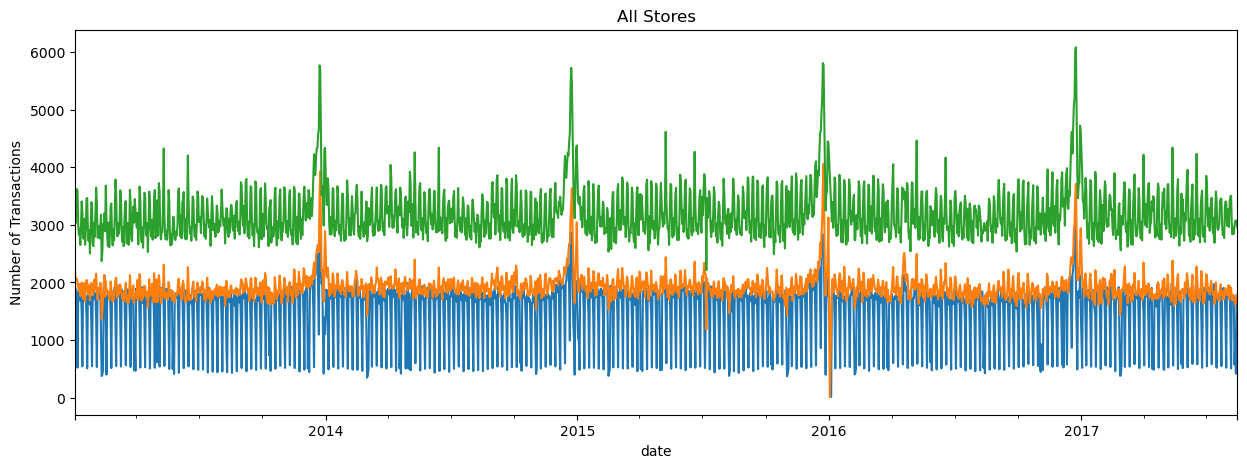

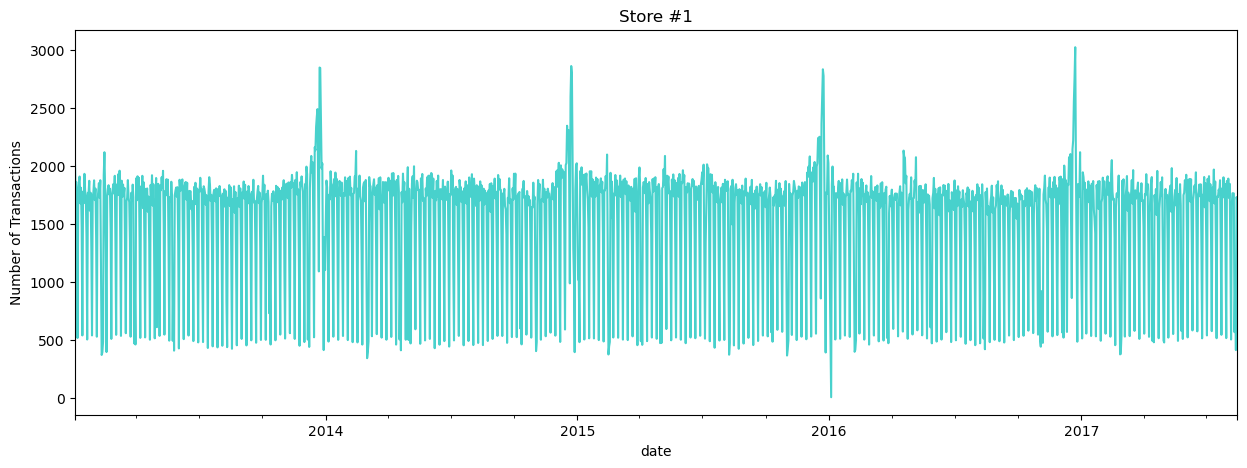

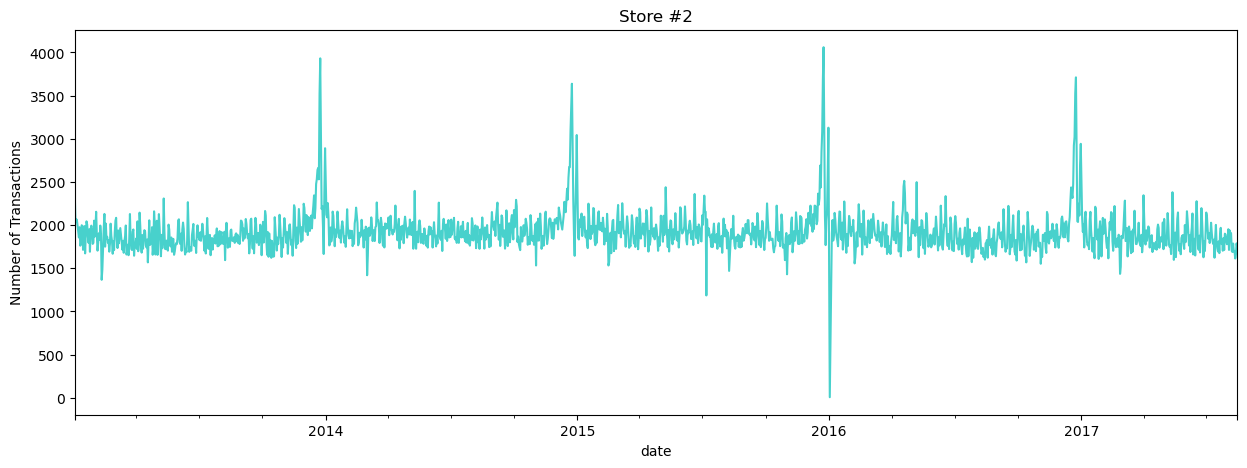

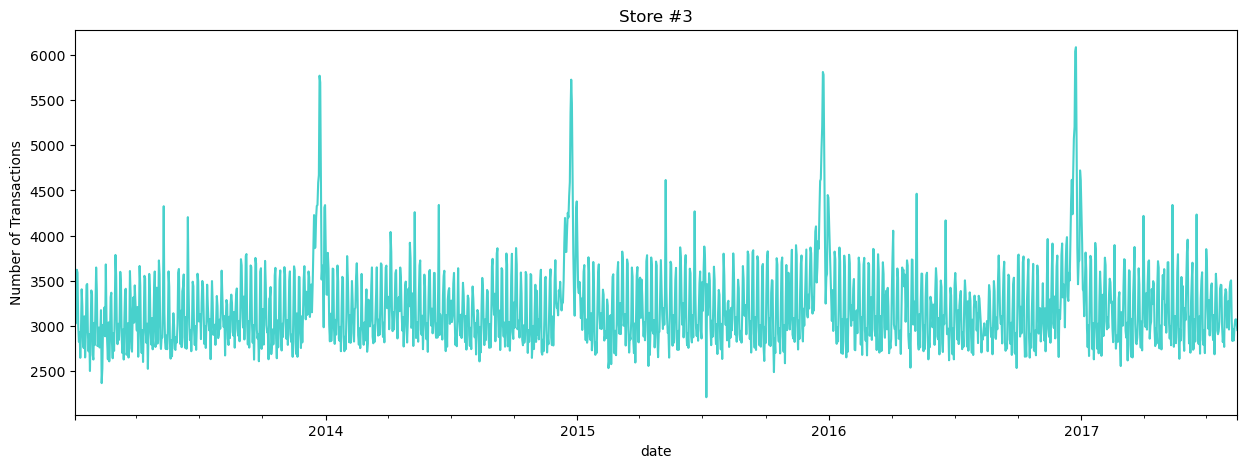

In [39]:
transactions_over_time(3)

The number of transactions doesn't show any dramatic changes. You can see some spikes for the holiday season but the stores aren't seeing an increasing in transaction number generally. And a slow slide in transaction number is seen for some.

- Please see function markdown for other excellent EDA options included (I'm just trying to keep the notebook from getting too long)

# 5. Oil Prices

## 5.1. Oil Price over Time

Text(0.5, 1.0, 'Large Changes in Oil Price')

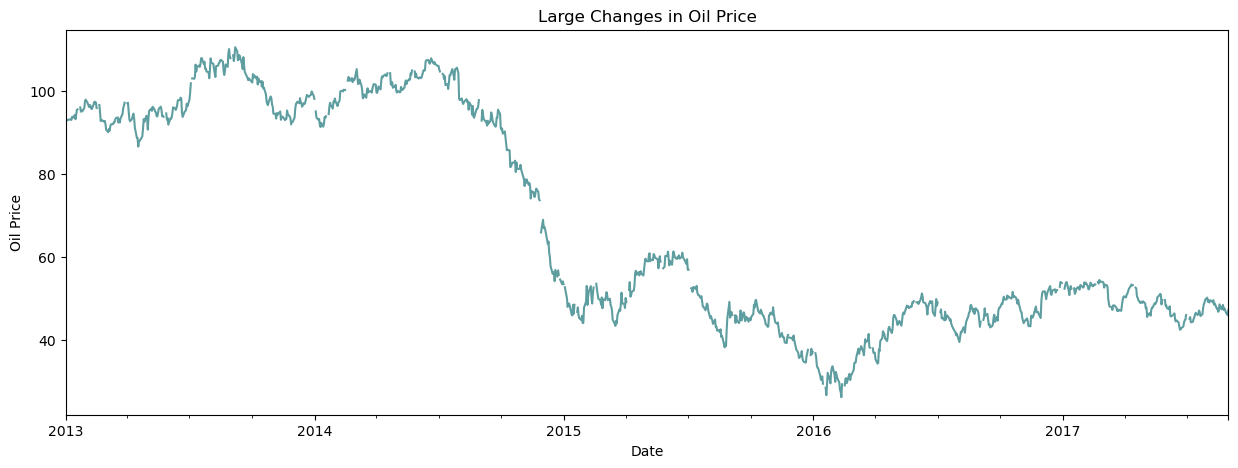

In [40]:
df_oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv", parse_dates=['date'])
df_oil['date'] = df_oil.date.dt.to_period('D')
df_oil = df_oil.set_index('date')

df_oil.plot(legend=False, color='cadetblue', figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title("Large Changes in Oil Price")

Text(0.5, 1.0, 'Some Linear Interpolation to Fill the Gaps')

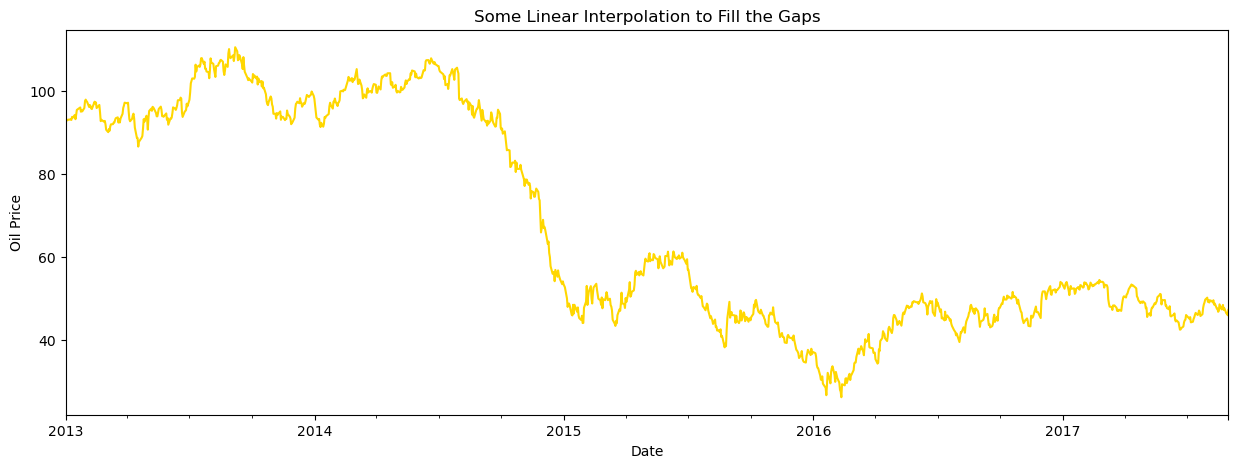

In [41]:
# Linear Interpolation  
df_oil = df_oil.dcoilwtico.resample('D').sum().reset_index()

df_oil['dcoilwtico'] = np.where(df_oil['dcoilwtico'] == 0, np.nan, df_oil['dcoilwtico'])
df_oil['dcoilwtico_interpolated'] = df_oil.dcoilwtico.interpolate()

df_oil = df_oil.set_index('date')

df_oil.dcoilwtico_interpolated.plot(color='gold', figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title("Some Linear Interpolation to Fill the Gaps")

No clear issues seen here! Should be be a perfectly good estimate for our requirements.

## 5.2. Correlation between Sales and Oil Price

In [42]:
sales_oil = total_sales.join(df_oil).dropna()
sales_oil = sales_oil.rename(columns={'dcoilwtico_interpolated':'Oil_Price', 'sales':'Total_Sales'})

Text(0.5, 1.0, 'Sales of the Day vs Oil Price \n \n With More Recent Points Being a Darker Hue')

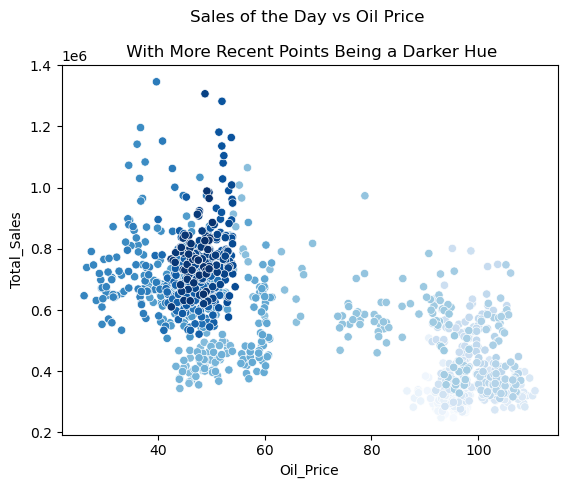

In [43]:
sns.scatterplot(data=sales_oil, x='Oil_Price', y='Total_Sales', hue='date', palette="Blues", legend=False)
plt.title(f"Sales of the Day vs Oil Price \n \n With More Recent Points Being a Darker Hue")

- A clear correlation can be seen between sales and oil price.
- But with more stores opening and total sales increasing over time, can we really say that this (negative) correlation is due to oil prices falling.
-The hue on date has been included to keep me wary of potential apophenia.

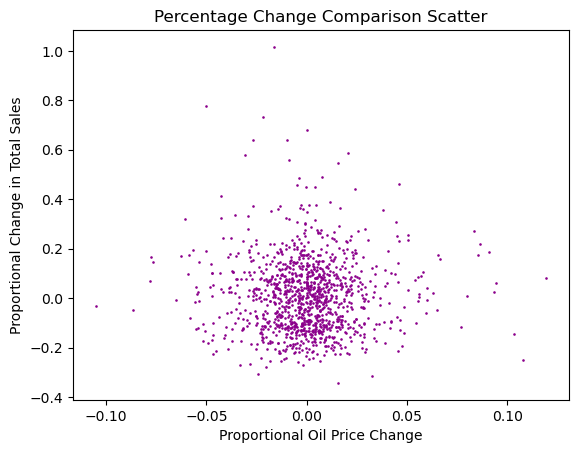

Correlation =  -0.01212653853980668


In [44]:
sales_oil['sales_percent_change']=sales_oil.Total_Sales.pct_change()
sales_oil['price_percent_change']=sales_oil.Oil_Price.pct_change()

plt.scatter(sales_oil.price_percent_change , sales_oil.sales_percent_change, marker='.', s=3, color='darkmagenta')
plt.title('Percentage Change Comparison Scatter')
plt.xlabel('Proportional Oil Price Change')
plt.ylabel('Proportional Change in Total Sales')
plt.show()

correlation = sales_oil.sales_percent_change.corr(sales_oil.price_percent_change)
print('Correlation = ', correlation)

- Total sales are more or less unresponsive to changes in oil prices.

- I feel that a look into transactions too is necessary.

## 5.2. Sales vs Transactions

In [45]:
total_transactions = df_transactions.groupby('date').sum().drop(columns=['store_nbr'])

In [46]:
sales_transactions_oil = sales_oil.join(total_transactions).dropna()
sales_transactions_oil['transactions_percent_change'] = sales_transactions_oil.transactions.pct_change()

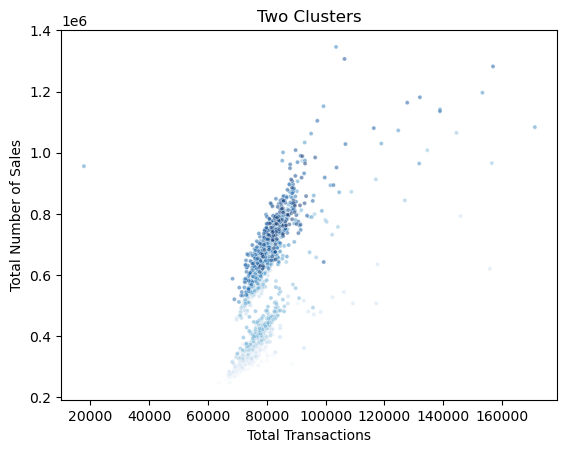

In [47]:
sns.scatterplot(data=sales_transactions_oil, x='transactions', y='Total_Sales', hue='date', palette="Blues", legend=False, alpha=0.5, marker='.')
plt.title(f"Sales of the Day vs Trasactions \n \n With More Recent Points Being a Darker Hue")
plt.title('Two Clusters')
plt.xlabel('Total Transactions')
plt.ylabel('Total Number of Sales')
plt.show()

The hue on date helps us see that the lower cluster (with less sales per transaction) is missing the more recent points.

Text(0.5, 1.0, 'Steady Increase in the Average Number of Sales Per Transaction')

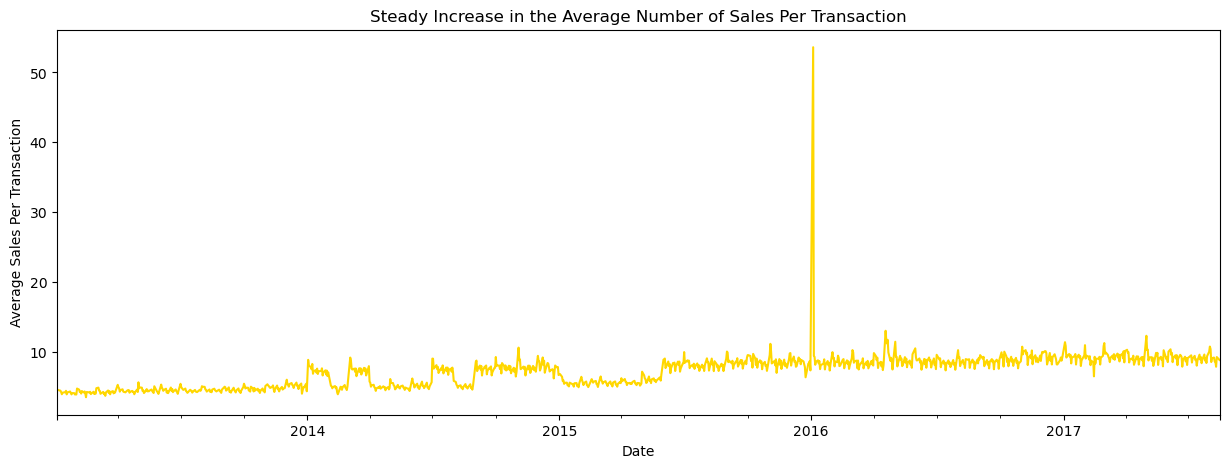

In [48]:
sales_transactions_oil['Sales_Per_Transaction']=sales_transactions_oil.Total_Sales / sales_transactions_oil.transactions

sales_transactions_oil.Sales_Per_Transaction.plot(legend=False, color='gold', figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Average Sales Per Transaction')
plt.title("Steady Increase in the Average Number of Sales Per Transaction")

There are many potential explanations for this. For one many store have seen a decrease in number of transactions. Perhaps people are fitting more shopping into fewer trips to the supermarket. Maybe there was an article in a big newspaper stating how less trips to the supermarket could make you happier?

But also lower fuel prices may also leave people feeling more affluent, and therefore spending more.

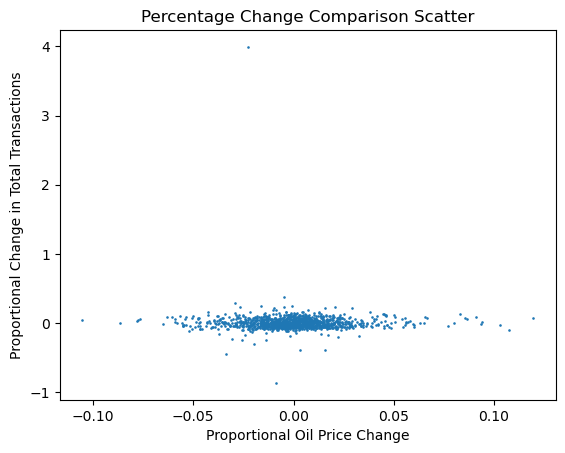

Correlation =  -0.011186852683657378


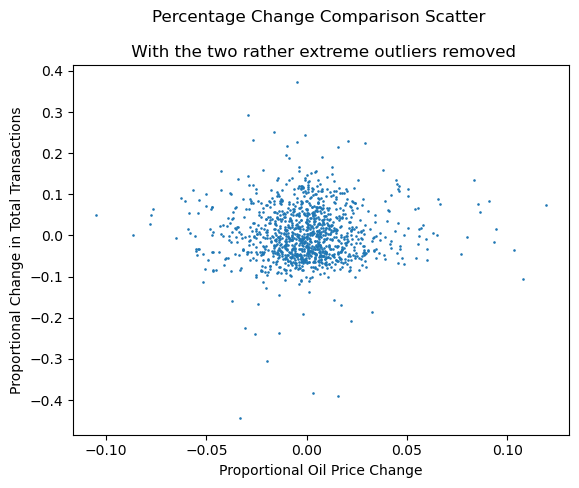

In [49]:
plt.scatter(sales_transactions_oil.price_percent_change , sales_transactions_oil.transactions_percent_change, marker='.', s=3)
plt.title('Percentage Change Comparison Scatter')
plt.xlabel('Proportional Oil Price Change')
plt.ylabel('Proportional Change in Total Transactions')
plt.show()

correlation = sales_transactions_oil.transactions_percent_change.corr(sales_transactions_oil.price_percent_change)
print('Correlation = ', correlation)

plt.scatter(sales_transactions_oil.price_percent_change[(sales_transactions_oil.transactions_percent_change<3) & (sales_transactions_oil.transactions_percent_change>-0.6)] , sales_transactions_oil.transactions_percent_change[(sales_transactions_oil.transactions_percent_change<3) & (sales_transactions_oil.transactions_percent_change>-0.6)], marker='.', s=3)
plt.title(f'Percentage Change Comparison Scatter \n \n With the two rather extreme outliers removed')
plt.xlabel('Proportional Oil Price Change')
plt.ylabel('Proportional Change in Total Transactions')
plt.show()

Again no correlation between changes in oil price and change in number of transactions

Text(0.5, 1.0, 'Transactions vs Oil Price \n \n With More Recent Points Being a Darker Hue')

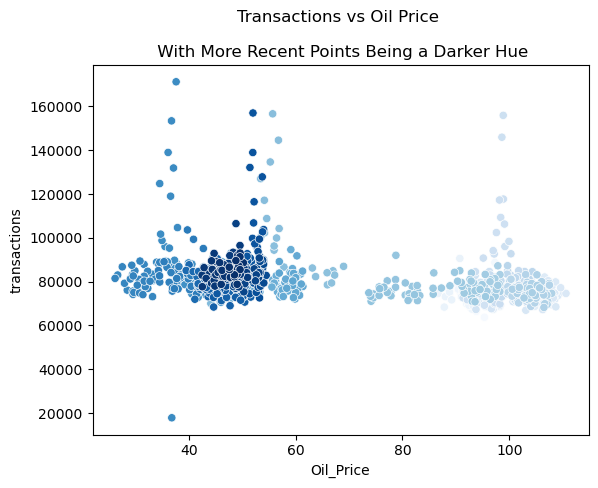

In [50]:
sns.scatterplot(data=sales_transactions_oil, x='Oil_Price', y='transactions', hue='date', palette="Blues", legend=False)
plt.title(f"Transactions vs Oil Price \n \n With More Recent Points Being a Darker Hue")

Taking a look at the monthly average transactions we can see that the seasonal spikes are far more important than the oil price!

In [51]:
a = df_transactions.groupby('date').mean().drop(columns=['store_nbr'])
a["date"]=a.index
a["year"] = a.date.dt.year
a = a.drop(columns='date')
a = a.resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year
a.date=a.date.astype(str)
px.line(a, x='date', y='transactions', color='year', title ="Monthly Average Transactions | To Explain the Spikes")

## 5.3. Sales Per Transaction vs Oil Price

Text(0.5, 1.0, 'Averge Number of Sales Per Transaction against Oil Price \n \n With More Recent Points Being a Darker Hue')

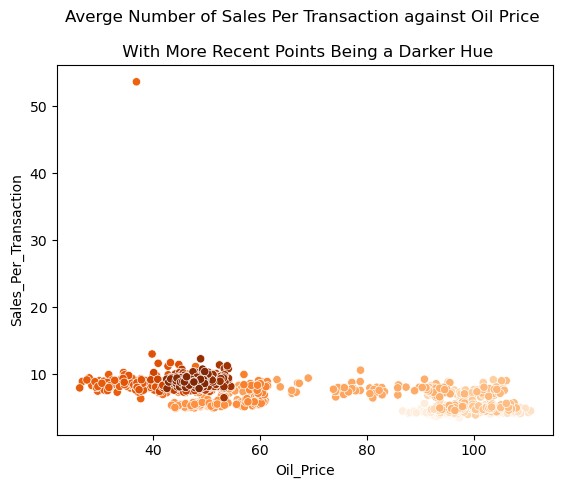

In [52]:
sns.scatterplot(data=sales_transactions_oil, x='Oil_Price', y='Sales_Per_Transaction', hue='date', palette="Oranges", legend=False)
plt.title(f"Averge Number of Sales Per Transaction against Oil Price \n \n With More Recent Points Being a Darker Hue")

Text(0.5, 1.0, 'Averge Number of Sales Per Transaction against Oil Price \n \n With More Recent Points Being a Darker Hue \n \n  And the most Extreme Outlier Removed')

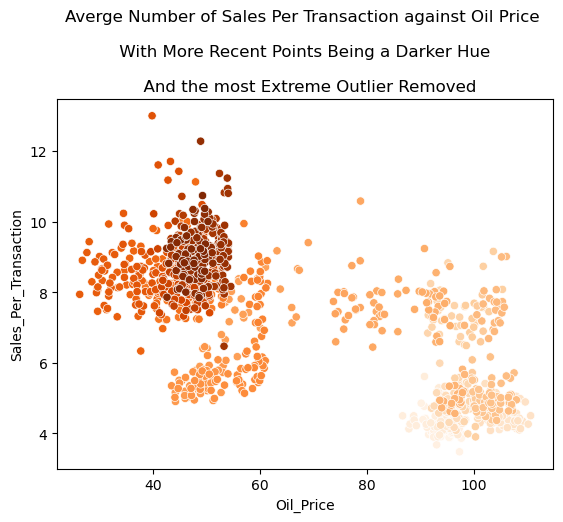

In [53]:
sns.scatterplot(data=sales_transactions_oil[sales_transactions_oil.Sales_Per_Transaction<20], x='Oil_Price', y='Sales_Per_Transaction', hue='date', palette="Oranges", legend=False)
plt.title(f"Averge Number of Sales Per Transaction against Oil Price \n \n With More Recent Points Being a Darker Hue \n \n  And the most Extreme Outlier Removed")

Again some clustering of datapoints. It appears that when the Oil price moves above around \$60 the number of purchases people are willing to make per transaction falls.

So lets try a treshold. An easy feature to add that might really help our model.

In [54]:
Expensive_Oil_Threshold = 60

In [55]:
sales_transactions_oil['Expensive_Oil']=sales_transactions_oil.Oil_Price >= Expensive_Oil_Threshold

<AxesSubplot:xlabel='Oil_Price', ylabel='Sales_Per_Transaction'>

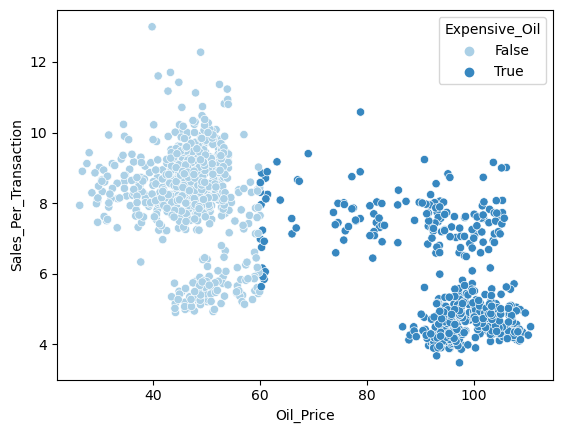

In [56]:
sns.scatterplot(data=sales_transactions_oil[sales_transactions_oil.Sales_Per_Transaction<20], x='Oil_Price', y='Sales_Per_Transaction', hue='Expensive_Oil', palette="Blues")

In [57]:
df_sales = df_sales.join(df_oil)

In [58]:
df_sales['Expensive_Oil'] = df_sales.dcoilwtico_interpolated >= Expensive_Oil_Threshold

In [59]:
def oil_price_effect(df=df_sales, STORE_NBR=1, family='AUTOMOTIVE'):
    sns.scatterplot(data = df.loc[:, STORE_NBR, family], x='dcoilwtico', y='sales', hue='Expensive_Oil', palette="GnBu")
    plt.title(f"Store {STORE_NBR} {family.title()} Sales")
    plt.show()

In [60]:
# for fam in departments:
#     plt.clf()
#     oil_price_effect(family=fam)

Looks like it may be a powerful feature for some families!

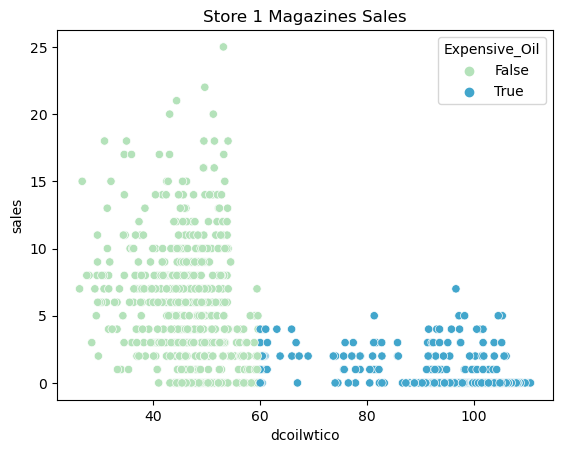

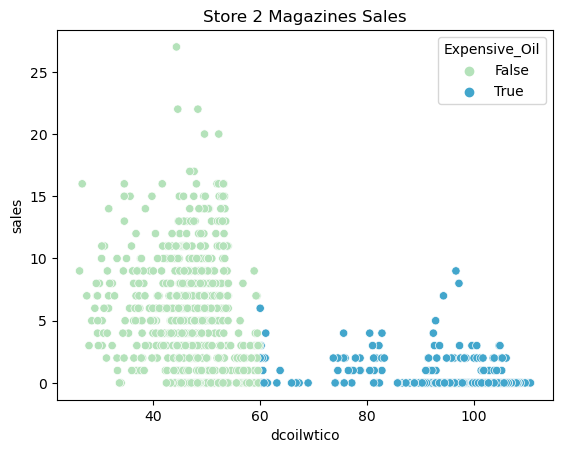

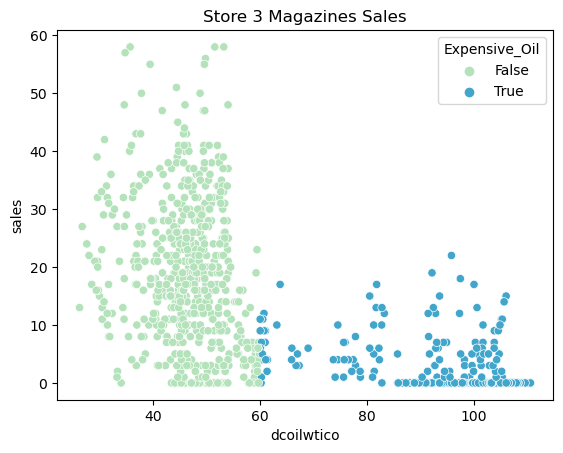

In [61]:
for store in range(1,4):
    plt.clf()
    oil_price_effect(STORE_NBR=store, family='MAGAZINES')

In [62]:
submission = pd.read_csv("/kaggle/input/StoreSalesForecastingSub/submission.csv")
submission.to_csv('submission.csv', index=False)

### I then also went on to build a boosted hybrid model and have included all the details in this second notebook.
### Please take a look:
https://www.kaggle.com/kennytanner/store-sales-forecasting-with-boosted-hybrid-model/